### Deep Dive into A/B Testing and Sample Size Estimates

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In this example, we're going to be testing the messaging on an account sign up button. We'd like to understand if Recipe A differs from Recipe B, and if we can be confident in the results.

There are several things that we need to know before we conduct this test. The **current conversion rate** and **desired lift in conversion** rate -- the former represents the current baseline conversion rate for our button; the latter represents the lift in conversion rate we'd need to see to move forward. This codealong is based on a thorough post by Nguyen Ngo here: https://towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f

In [44]:
# code examples presented in Python
bcr = 0.10  # baseline conversion rate
d_hat = 0.02  # difference between the groups

### Control and Test Groups

Hypothetically, let's say that we've randomly selected two distinct groups of 100 users to recieve this experiment.

In [52]:
A = 1000
B = 1000

In [63]:
import scipy.stats as scs
import pandas as pd

def generate_data(N_A, N_B, p_A, p_B, days=None, control_label='A',
                  test_label='B'):
    """Returns a pandas dataframe with fake CTR data
    Example:
    Parameters:
        N_A (int): sample size for control group
        N_B (int): sample size for test group
            Note: final sample size may not match N_A provided because the
            group at each row is chosen at random (50/50).
        p_A (float):  conversion rate; conversion rate of control group
        p_B (float): conversion rate; conversion rate of test group
        days (int): optional; if provided, a column for 'ts' will be included
            to divide the data in chunks of time
            Note: overflow data will be included in an extra day
        control_label (str)
        test_label (str)
    Returns:
        df (df)
    """

    # initiate empty container
    data = []

    # total amount of rows in the data
    N = N_A + N_B

    group_bern = scs.bernoulli(0.5)

    # initiate bernoulli distributions to randomly sample from
    A_bern = scs.bernoulli(p_A)
    B_bern = scs.bernoulli(p_A)

    for idx in range(N):
        # initite empty row
        row = {}
        # for 'ts' column
        if days is not None:
            if type(days) == int:
                row['ts'] = idx // (N // days)
            else:
                raise ValueError("Provide an integer for the days parameter.")
        # assign group based on 50/50 probability
        row['group'] = group_bern.rvs()

        if row['group'] == 0:
            # assign conversion based on provided parameters
            row['converted'] = A_bern.rvs()
        else:
            row['converted'] = B_bern.rvs()
        # collect row into data container
        data.append(row)

    # convert data into pandas dataframe
    df = pd.DataFrame(data)

    # transform group labels of 0s and 1s to user-defined group labels
    df['group'] = df['group'].apply(
        lambda x: control_label if x == 0 else test_label)

    return df

In [64]:
ab_data = generate_data(A, B, bcr, d_hat)

In [65]:
ab_summary = ab_data.pivot_table(values='converted', index='group', aggfunc=np.sum)
ab_summary['total'] = ab_data.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = ab_data.pivot_table(values='converted', index='group')

In [66]:
ab_summary

,converted,total,rate
group,,,
A,107,991,0.107972
B,93,1009,0.092170


### Control Group Distribution

In [67]:
A_converted = ab_summary.converted[0]
B_converted = ab_summary.converted[1]

A_total = ab_summary.total[0]
B_total ### Control and Test Groups= ab_summary.total[1]

A_cr = ab_summary.rate[0]
B_cr = ab_summary.rate[1]

Text(0, 0.5, 'probability')

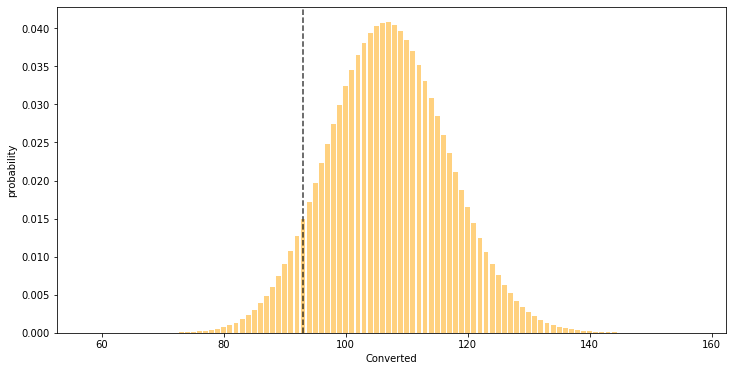

In [73]:
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(A_converted-49, A_converted+50, 100)
y = scs.binom(A_total, A_cr).pmf(x)
ax.bar(x, y, alpha=0.5, color='orange')
ax.axvline(x=B_converted, c='black', alpha=0.75, linestyle='--')
plt.xlabel('Converted')
plt.ylabel('probability')

### Comparison of Distributions

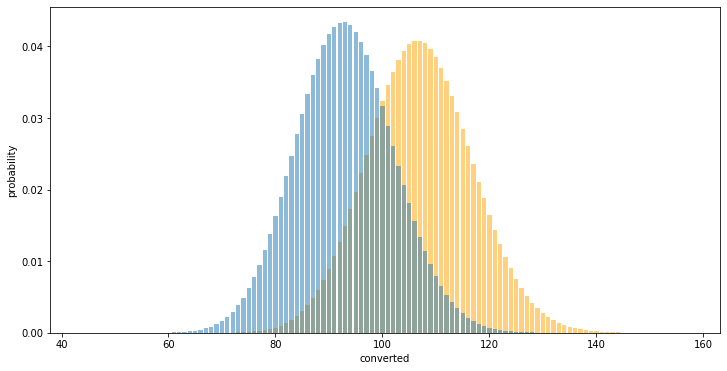

In [107]:
fig, ax = plt.subplots(figsize=(12,6));
xA = np.linspace(A_converted-49, A_converted+50, 100);
yA = scs.binom(A_total, A_cr).pmf(xA);
ax.bar(xA, yA, alpha=0.5, color='orange');
xB = np.linspace(B_converted-49, B_converted+50, 100);
yB = scs.binom(B_total, B_cr).pmf(xB);
ax.bar(xB, yB, alpha=0.5);
;plt.xlabel('converted');
plt.ylabel('probability');

In [92]:
# standard error of the mean for both groups
SE_A = np.sqrt(A_cr * (1-A_cr)) / np.sqrt(A_total)
SE_B = np.sqrt(B_cr * (1-B_cr)) / np.sqrt(B_total)
A_cr, B_cr, SE_A, SE_B

(0.10797174571140263,
 0.09217046580773043,
 0.009858425063980243,
 0.00910652033582941)

In [89]:
A_cr - B_cr

0.015801279903672194

In [90]:
d_hat

0.02

In [97]:
len(yB)

1000

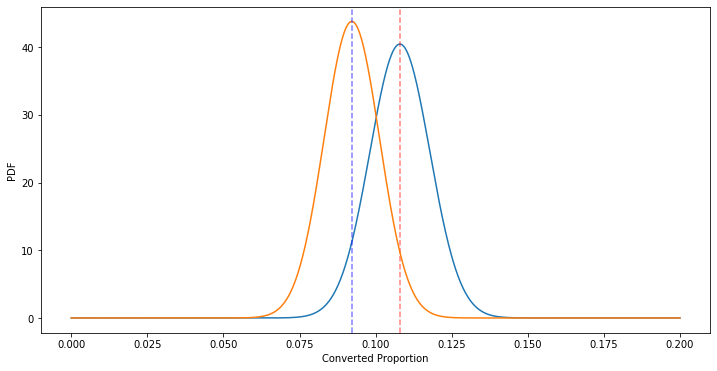

In [102]:
# plot the null and alternative hypothesis
fig, ax = plt.subplots(figsize=(12,6))


xA = np.linspace(0, .2, 1000)
xB = np.linspace(0, .2, 1000)
yA = scs.norm(A_cr, SE_A).pdf(x)
ax.plot(xA, yA)
ax.axvline(x=A_cr, c='red', alpha=0.5, linestyle='--')
yB = scs.norm(B_cr, SE_B).pdf(x)
ax.plot(xA, yB)
ax.axvline(x=B_cr, c='blue', alpha=0.5, linestyle='--')
plt.xlabel('Converted Proportion')
plt.ylabel('PDF');

## Finding sample size needed

In [127]:
Ax = .10
effect = .2

In [111]:
scs.norm(0, 1).ppf(0.8)

0.8416212335729143

In [137]:
def minimum_sample(bcr, effect, power=0.8, sig_level=0.05):
    
    #Normal distribution in order to calculate z scores
    standard_norm = scs.norm(0,1)
    
    #Z beta represents the probability that we reject H0 and accept Ha
    Z_beta = standard_norm.ppf(power)
    
    #Z alpha represents the probability that we cannot reject H0, and reject Ha
    Z_alpha = standard_norm.ppf(1-sig_level/2)
    
    #pooled probability is the equivalent of the average of our sample means between our groups
    pooled_prob = (bcr + bcr +effect) / 2
    
    #This is the equation needed to arrive at miniminum sample, assuming that power is 80%, and our stat sig level os 0.05
    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2
             / effect**2)
    
    return(min_N)

In [153]:
minimum_sample(bcr=0.12,effect=0.02, sig_level=0.01)

6604.456502212748